In [32]:
# ==== Part 0: Setup and Imports ====
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pprint import pprint

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import joblib

# ==== Configuration ====
RANDOM_STATE = 42
CSV_PATH = "diabetes_binary_health_indicators_BRFSS2015.csv"
OUTPUT_DIR = "model_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✅ Environment ready.")


✅ Environment ready.


In [34]:
# ==== Part 1: Load and Optimize Dataset ====

def load_and_optimize(csv_path: str):
    df = pd.read_csv(csv_path)

    # Convert known binary columns to small integer dtype
    binary_cols = [
        "HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", "HeartDiseaseorAttack",
        "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump", "AnyHealthcare",
        "NoDocbcCost", "DiffWalk", "Sex"
    ]
    for col in binary_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], downcast="unsigned")

    # Convert numeric columns
    for col in ["BMI", "MentHlth", "PhysHlth", "GenHlth", "Age", "Education", "Income"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], downcast="float")

    return df

# Load data
df = load_and_optimize(CSV_PATH)
print(f"✅ Loaded data: {df.shape}")
display(df.head())


✅ Loaded data: (253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1,1,1,40.0,1,0,0,0,0,1,0,1,0,5.0,18.0,15.0,1,0,9.0,4.0,3.0
1,0.0,0,0,0,25.0,1,0,0,1,0,0,0,0,1,3.0,0.0,0.0,0,0,7.0,6.0,1.0
2,0.0,1,1,1,28.0,0,0,0,0,1,0,0,1,1,5.0,30.0,30.0,1,0,9.0,4.0,8.0
3,0.0,1,0,1,27.0,0,0,0,1,1,1,0,1,0,2.0,0.0,0.0,0,0,11.0,3.0,6.0
4,0.0,1,1,1,24.0,0,0,0,1,1,1,0,1,0,2.0,3.0,0.0,0,0,11.0,5.0,4.0


In [36]:
# ==== Part 2: Select Features and Split Data ====

target = "Diabetes_binary"

# Selected 11 important features
features = [
    "GenHlth", "HighBP", "DiffWalk", "BMI", "HighChol",
    "Age", "HeartDiseaseorAttack", "PhysHlth", "Income",
    "Education", "PhysActivity"
]

X = df[features].copy()
y = df[target].astype(int)

# Split: 75% train, 25% test, and small validation set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Target positive rate:", y.mean().round(4))


Train: (171234, 11), Val: (19026, 11), Test: (63420, 11)
Target positive rate: 0.1393


In [38]:
# ==== Part 3: Preprocessing (Scaling numeric columns only) ====

numeric_cols = ["BMI", "GenHlth", "PhysHlth", "Age", "Education", "Income"]
binary_cols = [c for c in features if c not in numeric_cols]

def make_preprocessor():
    num_transformer = Pipeline([("scaler", StandardScaler())])
    preprocessor = ColumnTransformer([
        ("num", num_transformer, numeric_cols),
        ("bin", "passthrough", binary_cols)
    ])
    return preprocessor

preprocessor = make_preprocessor()
print("✅ Preprocessor ready. Feature count after transform:",
      preprocessor.fit_transform(X_train[:1]).shape[1])


✅ Preprocessor ready. Feature count after transform: 11


In [40]:
# ==== Part 4: Build XGBoost + SMOTEENN Pipeline ====

# Handle imbalance with scale_pos_weight
pos, neg = np.sum(y_train == 1), np.sum(y_train == 0)
scale_pos_weight = neg / pos

model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.5,
    eval_metric="auc",
    tree_method="hist",
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)

sampler = SMOTEENN(random_state=RANDOM_STATE)

pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("sampler", sampler),
    ("clf", model)
])

print("🚀 Training XGBoost + SMOTEENN...")
pipe.fit(X_train, y_train)
print("✅ Model trained successfully.")


🚀 Training XGBoost + SMOTEENN...
✅ Model trained successfully.



✅ Model Evaluation Metrics:
{'Accuracy': 0.8149,
 'Best Threshold': 0.8412441,
 'F1 (Test)': 0.4612,
 'F1 (Val)': 0.4695,
 'PR AUC': 0.4141,
 'Precision': 0.388,
 'ROC AUC': 0.8202,
 'Recall': 0.5684}


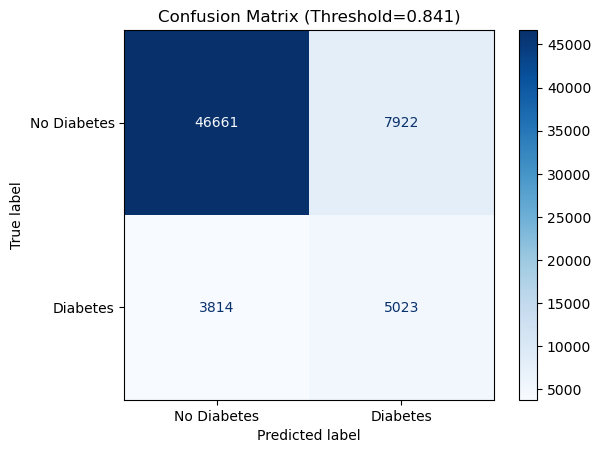

In [42]:
# ==== Part 5: Tune Threshold (F1-maximizing) and Evaluate ====

# Validation predictions
proba_val = pipe.predict_proba(X_val)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, proba_val)
f1s = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-12)
best_idx = f1s.argmax()
best_thr = thresholds[best_idx]

# Test predictions at best threshold
proba_test = pipe.predict_proba(X_test)[:, 1]
preds_test = (proba_test >= best_thr).astype(int)

# Metrics
metrics = {
    "Best Threshold": best_thr,
    "F1 (Val)": f1s[best_idx],
    "Accuracy": accuracy_score(y_test, preds_test),
    "Precision": precision_score(y_test, preds_test),
    "Recall": recall_score(y_test, preds_test),
    "F1 (Test)": f1_score(y_test, preds_test),
    "ROC AUC": roc_auc_score(y_test, proba_test),
    "PR AUC": average_precision_score(y_test, proba_test)
}

print("\n✅ Model Evaluation Metrics:")
pprint({k: round(v, 4) if isinstance(v, float) else v for k, v in metrics.items()})

# Confusion Matrix
cm = confusion_matrix(y_test, preds_test)
ConfusionMatrixDisplay(cm, display_labels=["No Diabetes", "Diabetes"]).plot(cmap="Blues")
plt.title(f"Confusion Matrix (Threshold={best_thr:.3f})")
plt.show()


In [44]:
# ==== Part 6: Save Model and Simple Docs ====

# Save full pipeline (preprocessing + sampler + model)
model_path = Path(OUTPUT_DIR) / "ml_xgboost_smoteenn_pipeline.pkl"
joblib.dump(pipe, model_path)
print(f"✅ Model saved to {model_path}")

# Simple usage documentation for developers
doc = f"""
Model Name: XGBoost + SMOTEENN (Diabetes Prediction)

Input format:
  - Columns: {features}
  - Each input sample must be a pandas DataFrame with these columns.

Example input:
  pd.DataFrame([{{"GenHlth": 3, "HighBP": 1, "DiffWalk": 0, "BMI": 28.0,
                 "HighChol": 1, "Age": 9, "HeartDiseaseorAttack": 0,
                 "PhysHlth": 5, "Income": 4, "Education": 5, "PhysActivity": 1}}])

To get prediction probability:
  model = joblib.load("{model_path}")
  prob = model.predict_proba(input_df)[:, 1]

To classify (0 or 1):
  pred = (prob >= {best_thr:.3f}).astype(int)
"""

with open(Path(OUTPUT_DIR) / "model_documentation.txt", "w") as f:
    f.write(doc.strip())

print("📘 Documentation saved next to model.")


✅ Model saved to model_output/ml_xgboost_smoteenn_pipeline.pkl
📘 Documentation saved next to model.
